In [23]:
import numpy as np
import pandas as pd
pd.set_option('display.float_format', '{:.3f}'.format)
import iris
import iris.coord_categorisation
import sys
import time
import datetime
from datetime import datetime
from statsmodels.graphics.mosaicplot import mosaic
import seaborn as sns

sys.path.insert(1, '../Finding_AMAX_Events')
from Identify_Events_Functions import *
from New_Identify_Events_Functions import *

sys.path.insert(1, '../../ProcessEvents')
from Convert_to_Profiles_Functions import *
from Get_Events_Functions import *
from Steef_Functions import *

sys.path.insert(1, '../../AnalyseProfiles')
from Plot_events_functions import *

home_dir = '/nfs/a319/gy17m2a/PhD/'
home_dir2 = '/nfs/a161/gy17m2a/PhD/'

em = 'bb208'
yrs_range= '2060_2081'
sample_cube = iris.load(home_dir + f'datadir/UKCP18_every30mins/2.2km_bng/{yrs_range}/{em}/bng_{em}a.pr206101.nc')[0][1,:,:]
tbo_vals = pd.read_csv(home_dir + 'datadir/RainGauge/interarrival_thresholds_CDD_noMissing.txt')

In [24]:
def get_month (df):
    # Step 2: Calculate the median (middle value)
    median_time = df['times'].median()

    # Step 3: Extract the month from the median value
    median_month = median_time.month

    # Convert month number to month name (optional)
    month_name = median_time.strftime('%B')

    return median_month

In [25]:
def create_event_characteristics_dict(this_event):
    
    max_quintile_molly=find_max_quintile(this_event['precipitation (mm)'],5)
    max_third_molly=find_max_quintile(this_event['precipitation (mm)'],3)
    max_quintile_steef=analyse_event(this_event['precipitation (mm)'])[0]
    duration = len(this_event) / 2
    DurationRange_personalised_allems = find_dur_category([1.5, 5.0, 11.5, 22.5, 166.5], ['0.25-2.10 hr', '2.10-6.45 hr', '6.45-19.25 hr', '19.25+ hr'], duration)
    DurationRange_notpersonalised = find_dur_category([0.25, 2.10, 6.45, 19.25, 1000], 
                                                      ['0.25-2.10 hr', '2.10-6.45 hr', '6.45-19.25 hr', '19.25+ hr'], duration)
    return {
        "season" : get_season(this_event['times'][0]),
        'duration':duration,
        "DurationRange_personalised_allems": DurationRange_personalised_allems,
        'DurationRange_notpersonalised':DurationRange_notpersonalised,
        "year":extract_year(this_event),
        "month":get_month(this_event),
        'Volume': sum(this_event['precipitation (mm)'].values),
        'max_intensity': this_event['precipitation (mm)'].max() *2,
        "max_quintile_molly":max_quintile_molly,
        "max_third_molly": max_third_molly,
        'max_quintile_steef' :max_quintile_steef,
        'Loading_profile_molly' :quintile_mapping[max_quintile_molly],
        'Loading_profile_third_molly':quintile_mapping_thirds[max_third_molly],
        'Loading_profile_steef':quintile_mapping[max_quintile_steef],
        'D50_index': calculate_D50(this_event['precipitation (mm)'])[1]
    }

In [26]:
def calculate_D50(precipitation_values):
    """
    Calculate D50, the point in time when 50% of cumulative precipitation has occurred during an event.
    
    Parameters:
    - precipitation_values: A list or array of precipitation values for a given event.
    
    Returns:
    - D50: The percentage of the event elapsed when 50% of cumulative precipitation has occurred.
    - D50_index: The index where 50% of cumulative precipitation has occurred.
    - cumulative_precip: The cumulative precipitation values for the event.
    """
    # Ensure input is a numpy array
    precipitation_values = np.array(precipitation_values)
    
    # Step 1: Calculate the cumulative precipitation
    cumulative_precip = np.cumsum(precipitation_values)
    
    # Step 2: Determine the total precipitation
    total_precip = cumulative_precip[-1]
    
    # Step 3: Find the index where 50% of the total precipitation is reached
    halfway_precip = total_precip / 2.0
    D50_index = np.where(cumulative_precip >= halfway_precip)[0][0]  # First index where cumulative precipitation >= 50%
    
    # Step 4: Calculate the percentage of the event duration (D50)
    total_timesteps = len(precipitation_values)
    D50 = (D50_index / (total_timesteps - 1)) * 100

    return D50, D50_index, cumulative_precip

def find_dur_category (bin_edges, duration_labels, duration):
    # Create a pandas Series with the duration
    # Use pd.cut to assign the duration to a bin
    binned_duration = pd.cut(pd.Series([duration]), bins=bin_edges, labels=duration_labels, right=True,  include_lowest=True)
    return binned_duration.iloc[0]

def create_profiles_dict(this_event):
    dimensionless_cumulative_rainfall, dimensionless_cumulative_times = create_huff_curves(this_event['precipitation (mm)'])
    interpolated_cumulative_rainfall, interpolated_times = interpolate_rainfall(dimensionless_cumulative_rainfall,12)
    irain_14vals, irain_times_14vals = create_irain_profile(interpolated_cumulative_rainfall, True)
    irain, irain_times = create_irain_profile(interpolated_cumulative_rainfall, False)
    return {
        "dimensionless_cumulative_rainfall" : dimensionless_cumulative_rainfall,
        'dimensionless_cumulative_times':dimensionless_cumulative_times,
        "interpolated_cumulative_rainfall": interpolated_cumulative_rainfall,
        'interpolated_times':interpolated_times,
        "irain_14vals":irain_14vals,
        'irain_times_14vals': irain_times_14vals,
        "irain":irain,
        "irain_times": irain_times} 


def plot_precipitation_with_D50(ax, precipitation_values, D50_index, cumulative_precip, D50):
    """
    Plot the precipitation event and indicate the D50 point on the plot.
    
    Parameters:
    - ax: The axis object to plot the data on.
    - precipitation_values: A list or array of precipitation values for a given event.
    - D50_index: The index where 50% of cumulative precipitation has occurred.
    - cumulative_precip: The cumulative precipitation values for the event.
    - D50: The percentage of the event elapsed when 50% of cumulative precipitation has occurred.
    """
    total_timesteps = len(precipitation_values)

    # Plot precipitation data
    ax.bar(range(total_timesteps), precipitation_values, color='blue', alpha=0.6)
    ax.set_xlabel('Time Step')
    ax.set_xticks(range(total_timesteps))
    #ax.set_ylabel('Precipitation (mm)', color='blue')
    ax.tick_params(axis='y', labelcolor='blue')

    # Plot cumulative precipitation with a second y-axis
    ax2 = ax.twinx()
    ax2.plot(range(total_timesteps), cumulative_precip, color='green', label='Cumulative Precipitation', lw=2)
    #ax2.set_ylabel('Cumulative Precipitation (mm)', color='green')
    ax2.tick_params(axis='y', labelcolor='green')

    # Add vertical line for D50
    ax.axvline(D50_index, color='red', linestyle='solid', lw=2, label=f'D50 = {D50:.2f}%')

    # Title and legend
    #ax.set_title('Precipitation Event and D50')
    ax.legend(loc='upper left')
    #ax2.legend(loc='upper right')

In [27]:
def plot_histogram_for_duration(event_props_dict, variable, duration, ax, bins=10):
    """
    Plots a histogram for a specified variable for a given duration category on a specified axis.

    Parameters:
    - event_props_dict: Dictionary containing event properties.
    - variable: The variable to plot (e.g., 'Volume' or 'Intensity').
    - duration: The specific duration category to plot.
    - ax: The axis to plot on.
    - bins: Number of bins for the histogram (default is 10).
    """
    # Step 1: Convert event_props_dict to a pandas DataFrame
    data = []
    for event, props in event_props_dict.items():
        data.append({variable: props[variable], 'Duration': props['DurationRange_personalised_allems']})

    df = pd.DataFrame(data)

    # Filter the DataFrame for the specified duration
    duration_data = df[df['Duration'] == duration]

    # Plot histogram for the specified duration
    if not duration_data.empty:
        ax.hist(duration_data[variable], bins=bins, alpha=0.5, edgecolor='black')
        #ax.set_title(f"{variable} Distribution - {duration}", fontsize=12)
        #ax.grid(True)
    else:
        pass
        #ax.set_title(f"{variable} Distribution - {duration} (No Data)", fontsize=12)
        #ax.grid(True)

    # Set y-axis label to the specific duration bin it refers to
    ax.set_ylabel(duration, fontsize=10, rotation=0)

    # Remove y-tick labels
    ax.set_yticks([])

In [28]:
quintile_mapping = {1: 'F2', 2: 'F1', 3: 'C', 4: 'B1', 5: 'B2'}
quintile_mapping_thirds = {1: 'F', 2: 'C', 3: 'B'}

## Create one set of events across all gauges

In [46]:
start_time = time.time()
all_gauge_top_18_6h_events =[]
for gauge_num in range(0,11):
    print(gauge_num)
    Tb0, idx_2d = find_gauge_Tb0_and_location_in_grid(tbo_vals, gauge_num, sample_cube)
    start_time3 = time.time()
    full_timeslice_cube = iris.load(home_dir + f'datadir/Gauge_Timeslices/2060_2081/{em}/gauge{gauge_num}_farFuture.nc')[0]
    my_duration = time.time() - start_time3
    print(f"Loading cube took {my_duration:.4f} seconds.")  
    
    start_time4 = time.time()
    precip_data = full_timeslice_cube.data
    time_coord = full_timeslice_cube.coord('time')
    my_duration = time.time() - start_time4
    print(f"Loading data took {my_duration:.4f} seconds.")  
    
    start_time2 = time.time()
    my_events = my_find_independent_events(precip_data, time_coord, Tb0)
    my_duration = time.time() - start_time2
    print(f"My code took {my_duration:.4f} seconds.")  
    
    start_time3 = time.time()
    top_18_6h_events = find_top_n_events_for_duration(my_events, n_events = 18, duration_in_hrs = 6)
    my_duration = time.time() - start_time3
    print(f"My code took {my_duration:.4f} seconds.")  
    
    all_gauge_top_18_6h_events.extend(top_18_6h_events)
my_duration = time.time() - start_time
print(f"My code took {my_duration:.4f} seconds.")    

0
Loading cube took 0.2914 seconds.
Loading data took 0.0288 seconds.
My code took 41.2045 seconds.
My code took 0.4113 seconds.
1
Loading cube took 0.2883 seconds.
Loading data took 0.0295 seconds.
My code took 33.7498 seconds.
My code took 0.3699 seconds.
2
Loading cube took 0.2569 seconds.
Loading data took 0.0296 seconds.
My code took 35.0949 seconds.
My code took 0.3275 seconds.
3
Loading cube took 0.3235 seconds.
Loading data took 0.0417 seconds.
My code took 33.6945 seconds.
My code took 0.3953 seconds.
4
Loading cube took 0.3132 seconds.
Loading data took 0.0297 seconds.
My code took 35.6123 seconds.
My code took 0.3670 seconds.
5
Loading cube took 0.3187 seconds.
Loading data took 0.0431 seconds.


KeyboardInterrupt: 

## Plot event characteristics by event duration

In [30]:
events_dict={}
event_props_dict={}
event_profiles_dict = {}

for event_num, event in enumerate(all_gauge_top_18_6h_events):

    event_df = pd.DataFrame({'precipitation (mm)': event[1], 'times': event[2]})
    event_props = create_event_characteristics_dict(event_df)
    event_profiles = create_profiles_dict(event_df)
    
    events_dict[event_num]  =event_df
    event_props_dict[event_num] =  event_props
    event_profiles_dict[event_num] = event_profiles

In [9]:
# volumes = [event['Volume'] for event in event_props_dict.values()]
# durations = [event['DurationRange_personalised_allems'] for event in event_props_dict.values()]

## Plot seasonal plots

In [37]:
months = [event['month'] for event in event_props_dict.values()]
months_df = pd.DataFrame({'month':months})

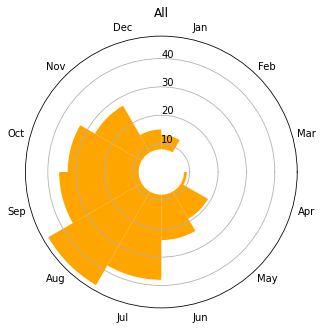

In [43]:
##########################################
####### Circular Histograms ##############
##########################################
N = 12
bottom = 8
max_height = 4

circular_bins = np.linspace(0.0, 2 * np.pi, N, endpoint=False)
circular_bins = np.append(circular_bins, 2 * np.pi)
circular_plot_position = circular_bins + 0.5*np.diff(circular_bins)[0]
circular_plot_position = circular_plot_position[:-1]
circular_plot_position = circular_plot_position + 0.5*np.pi

month_of_event =  np.array(months)

count3 = months_df['month'].value_counts().sort_index()
count3 = count3.reindex(list(range(count3.index.min(),count3.index.max()+1)),fill_value=0)

radii = max_height*np.random.rand(N)
width = (2*np.pi) / N

fig = plt.figure(figsize=(20,5))
ax3 = plt.subplot(111, polar=True)
ax3.bar(circular_plot_position, count3.iloc[::-1], width=width, bottom=bottom, color="orange")

ax3.set_title("All")
ax3.set_rlabel_position(90)
ax3.xaxis.grid(False)
ax3.set_xticks(circular_plot_position - 0.5*np.pi)
ax3.set_xticklabels(['Mar', 'Feb', 'Jan',
                     'Dec', 'Nov', 'Oct',
                    'Sep', 'Aug', 'Jul',
                    'Jun', 'May', 'Apr']);

### Compare to normal histogram

### Plot summary statistics

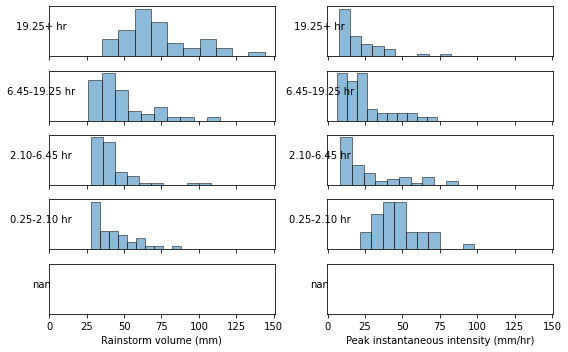

In [13]:
custom_duration_order = ['19.25+ hr', '6.45-19.25 hr', '2.10-6.45 hr', '0.25-2.10 hr', 'nan']

# Create a figure with subplots for different variables
n_categories = len(custom_duration_order)
n_variables = 2  # For Volume and Intensity
fig, axs = plt.subplots(n_categories, n_variables, figsize=(8, 1 * n_categories), sharex=True)  # 2 columns for different variables

# Call the function for each variable in each duration category
for i, duration in enumerate(custom_duration_order):
    plot_histogram_for_duration(event_props_dict, variable='Volume', duration=duration, ax=axs[i, 0])
    plot_histogram_for_duration(event_props_dict, variable='max_intensity', duration=duration, ax=axs[i, 1])

    # Set x-axis labels for each column
    if i ==4:
        axs[i, 0].set_xlabel("Rainstorm volume (mm)", fontsize=10)
        axs[i, 1].set_xlabel("Peak instantaneous intensity (mm/hr)", fontsize=10)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

### Plot loading profiles

In [14]:
profiles = []
for one_dict, the_dict in event_props_dict.items():
    profiles.append(the_dict['Loading_profile_molly'])
profiles_df =pd.DataFrame({"Loading_profile_molly":profiles})

In [15]:
quintile_cats = ['F2','F1', 'C', 'B1', 'B2']
color_mapping = {'F2': (0.0, 0.0, 1.0, 0.6),   'F1': (0.0, 0.6902, 1.0, 0.6),
    'C': (0.5, 0.5, 0.5, 0.6), 'B1': (0.8039, 0.0, 0.0, 0.6),'B2': (0.5451, 0.0, 0.0, 0.6)} 

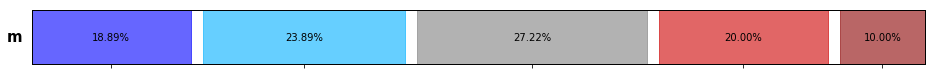

In [16]:
# Create the subplots
fig, axs = plt.subplots(figsize=(16, 1), sharex=True)
create_single_variable_mosaic_plot_pctlabels(axs, profiles_df, 'Loading_profile_molly', 
    quintile_cats, color_mapping, "m")

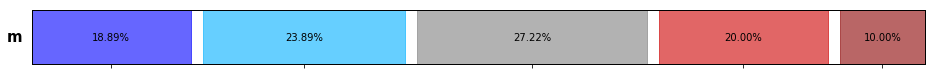

In [17]:
# Create the subplots
fig, axs = plt.subplots(figsize=(16, 1), sharex=True)

create_single_variable_mosaic_plot_pctlabels(axs, profiles_df, 'Loading_profile_molly', 
    quintile_cats, color_mapping, "m")

### Plot D50 stats

### Plot individual events to look at

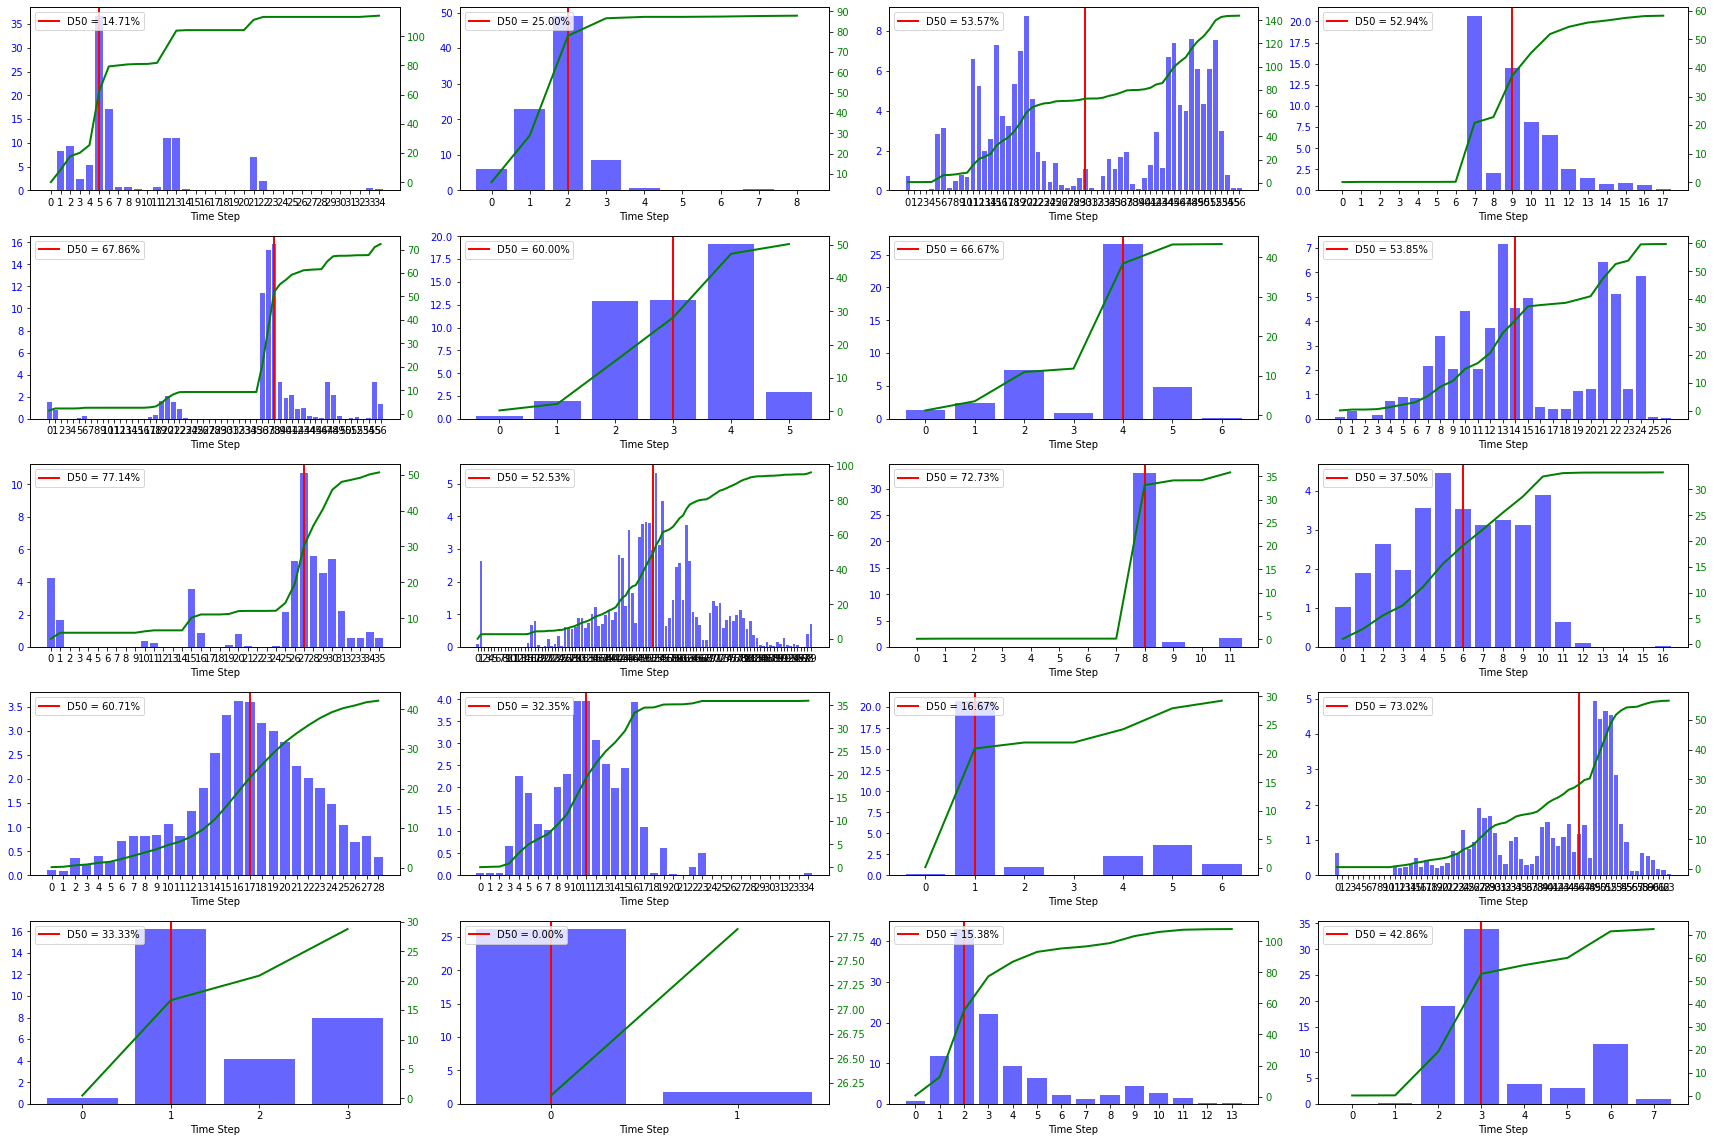

In [63]:
fig, axes = plt.subplots(5, 4, figsize=(24, 16))  # 2x2 grid of subplots
axes = axes.flatten()  # Flatten the axes array for easy iteration

# Loop through events and plot each one in its subplot
for i in range(0,20):
    this_event = events_dict[i]
    D50, D50_index, cumulative_precip = calculate_D50(this_event['precipitation (mm)'])
    plot_precipitation_with_D50(axes[i], this_event['precipitation (mm)'], D50_index, cumulative_precip, D50)
    # axes[i].set_title(D50_index)

plt.tight_layout()  # Adjust spacing between subplots
plt.show()

### Example from one event

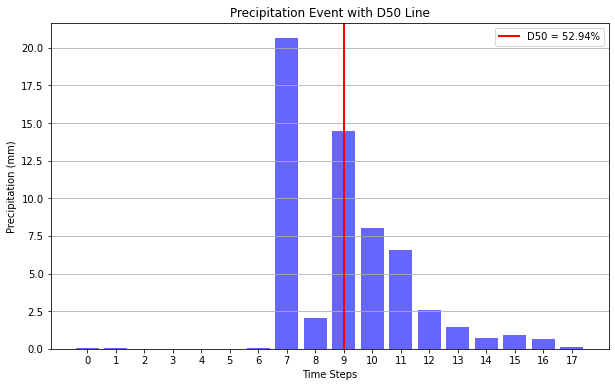

In [64]:
# Calculate D50
precipitation_values = events_dict[3]['precipitation (mm)']
D50, D50_index, cumulative_precip = calculate_D50(precipitation_values)
total_timesteps = len(precipitation_values)

# Plot precipitation data
plt.figure(figsize=(10, 6))
plt.bar(range(total_timesteps), precipitation_values, color='blue', alpha=0.6)
plt.axvline(D50_index, color='red', linestyle='solid', lw=2, label=f'D50 = {D50:.2f}%')

# Adding labels and title
plt.title('Precipitation Event with D50 Line')
plt.xlabel('Time Steps')
plt.ylabel('Precipitation (mm)')
plt.xticks(range(total_timesteps))  # Set x-ticks to match the time steps
plt.legend()
plt.grid(axis='y')

# Show the plot
plt.show()